# This code was designed to prove that we can make an estimator that works for an arbitrary function

# This code is meant to be run by Tensorflow 2.0 under Conda, the conda environment creating file is provided in the base folder of this repository

## The cell bellow suppresses the warnings from tf and other packages that are overly verbose

In [1]:
import warnings
warnings.filterwarnings('ignore')

## The imports are self explanatory

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Layer, Input
from keras import optimizers
from sklearn.metrics import r2_score
import gc
import os

Using TensorFlow backend.


# <span style="color:red">This function has been changed to a gaussian version of itself to test the generalization properties of the network</span>
## This function generates the dataset points for the test, feel free to modify it as you wish to see if the network can still fit it

In [3]:
f1 = lambda z,c,v: 1/(1 + np.exp((-z+c)*v))

In [4]:
f2 = lambda q,w,e: f1(q,w,e) + f1(q,-w,-e)

In [5]:
def generatePointsGaussian(vector_size,samples,deviation = 0.2):
    x = np.linspace(-np.pi*5/2,np.pi*5/2,vector_size)
    xmatrix = []
    ymatrix = []
    for i in range(0,samples):
        ymatrix.append(np.zeros(vector_size))
        xmatrix.append(x)
    xvector = np.array(xmatrix).reshape((vector_size*samples,))
    yvector = np.array(ymatrix).reshape((vector_size*samples,))
    for j in range(0,len(xvector)):
        deviationNow = deviation*f2(abs((xvector[j]/(np.pi*5/2))),0.2,35)
        yvector[j] = np.cos(xvector[j]) + np.random.normal(scale = deviationNow)
    return xvector,yvector

## This cell and the graph bellow are here as debug, showing how the function works

In [6]:
generatePointsGaussian(5,2)

(array([-7.85398163, -3.92699082,  0.        ,  3.92699082,  7.85398163,
        -7.85398163, -3.92699082,  0.        ,  3.92699082,  7.85398163]),
 array([-0.17267379, -0.54559129,  1.00005532, -0.53965029,  0.11280038,
         0.13967251, -0.76149794,  0.99952503, -0.51786639, -0.08134378]))

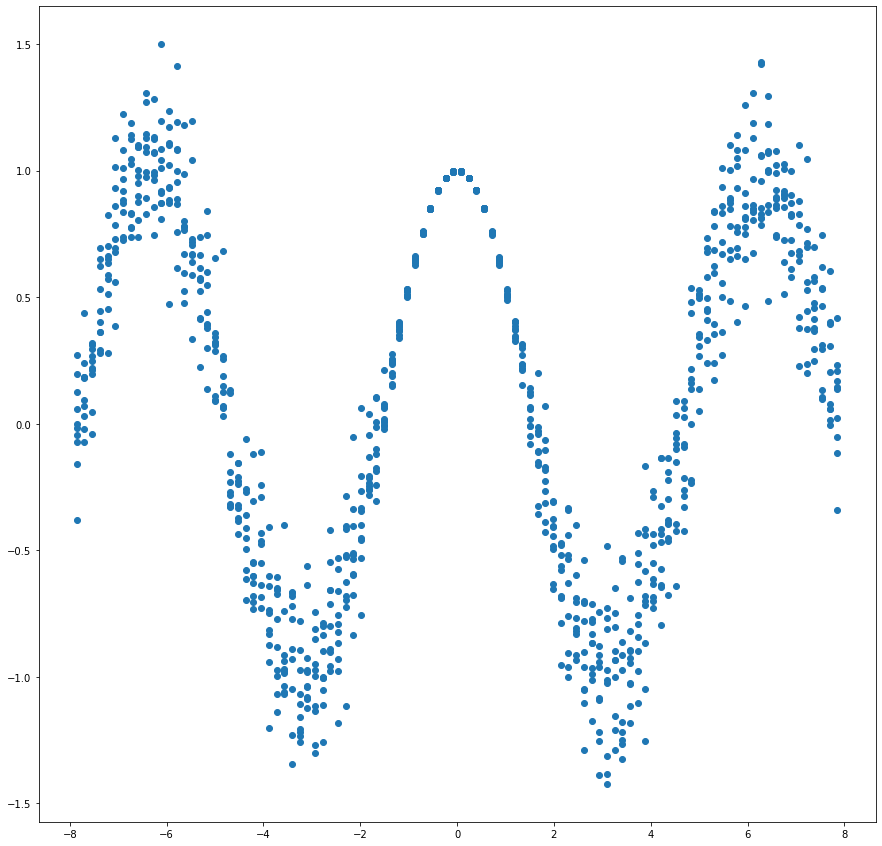

In [7]:
plt.figure(figsize=(15,15))
plt.scatter(*generatePointsGaussian(100,10))

## This function bellow will be the cost function for the mixture density network

In [8]:
def mdn_cost(mu, sigma, y):
    dist = tfp.distributions.Normal(loc=mu, scale=sigma)
    return tf.reduce_mean(-dist.log_prob(y))

## The neural network model bellow implements a simple neural network with fully connected layers that fits the data

In [9]:
xInputLayer = Input(shape=(1,))
yInputLayer = Input(shape=(1,))
layer1 = Dense(200,activation="sigmoid")(xInputLayer)
layer2 = Dense(200,activation="sigmoid")(layer1)
layer3 = Dense(200,activation="sigmoid")(layer2)
mu = Dense(1,activation="linear")(layer3)
sigma = Dense(1,activation = lambda x: tf.nn.elu(x)+1)(layer3)
lossFunction = mdn_cost(mu,sigma,yInputLayer)
model = Model(inputs=[xInputLayer,yInputLayer], outputs=[mu,sigma])
model.add_loss(lossFunction)
adamOptimizer = optimizers.Adam(learning_rate=0.00008,beta_1=0.7,beta_2=0.9)
adagradOptimizer  = optimizers.Adagrad()
sgdOptimizer  = optimizers.SGD()
model.compile(optimizer=adamOptimizer,metrics=['mse'])


In [10]:
def generatePoints(vector_size):
    x = np.zeros(vector_size)
    y = np.zeros(vector_size)
    for i in range(0,len(x)):
        x[i] = np.random.random()*np.pi*5 - np.pi*5/2
        y[i] = np.cos(x[i])
    return x,y

## Generate the data that will be used in the training and testing of the model

In [11]:
xtrain, ytrain = generatePointsGaussian(120,30,deviation=0.3)
xtest, ytest = generatePoints(30)

## The training phase is logged to a cache that is used bellow to show the network's progress over the epochs of training

In [12]:
history_cache = model.fit([xtrain, ytrain],
                          epochs=1000,
                          batch_size=10,
                          validation_split=0.2,
                          verbose = 1)

Train on 2880 samples, validate on 720 samples
Epoch 1/1000
2880/2880 [==============================] - 2s 554us/step - loss: 1.1338 - val_loss: 1.1269
Epoch 2/1000
2880/2880 [==============================] - 1s 351us/step - loss: 1.1219 - val_loss: 1.1311
Epoch 3/1000
2880/2880 [==============================] - 1s 350us/step - loss: 1.1201 - val_loss: 1.1315
Epoch 4/1000
2880/2880 [==============================] - 1s 365us/step - loss: 1.1221 - val_loss: 1.1348
Epoch 5/1000
2880/2880 [==============================] - 1s 349us/step - loss: 1.1227 - val_loss: 1.1312
Epoch 6/1000
2880/2880 [==============================] - 1s 361us/step - loss: 1.1205 - val_loss: 1.1259
Epoch 7/1000
2880/2880 [==============================] - 1s 352us/step - loss: 1.1228 - val_loss: 1.1274
Epoch 8/1000
2880/2880 [==============================] - 1s 351us/step - loss: 1.1216 - val_loss: 1.1263
Epoch 9/1000
2880/2880 [==============================] - 1s 350us/step - loss: 1.1192 - val_loss: 1.1310

2880/2880 [==============================] - 1s 346us/step - loss: 0.9790 - val_loss: 0.9821
Epoch 78/1000
2880/2880 [==============================] - 1s 345us/step - loss: 0.9775 - val_loss: 0.9830
Epoch 79/1000
2880/2880 [==============================] - 1s 344us/step - loss: 0.9748 - val_loss: 0.9878
Epoch 80/1000
2880/2880 [==============================] - 1s 345us/step - loss: 0.9743 - val_loss: 0.9807
Epoch 81/1000
2880/2880 [==============================] - 1s 348us/step - loss: 0.9721 - val_loss: 0.9785
Epoch 82/1000
2880/2880 [==============================] - 1s 347us/step - loss: 0.9699 - val_loss: 0.9782
Epoch 83/1000
2880/2880 [==============================] - 1s 345us/step - loss: 0.9688 - val_loss: 0.9787
Epoch 84/1000
2880/2880 [==============================] - 1s 347us/step - loss: 0.9675 - val_loss: 0.9706
Epoch 85/1000
2880/2880 [==============================] - 1s 343us/step - loss: 0.9617 - val_loss: 0.9895
Epoch 86/1000
2880/2880 [==========================

Epoch 153/1000
2880/2880 [==============================] - 1s 346us/step - loss: -0.0567 - val_loss: -0.0662
Epoch 154/1000
2880/2880 [==============================] - 1s 345us/step - loss: -0.0630 - val_loss: -0.0056
Epoch 155/1000
2880/2880 [==============================] - 1s 345us/step - loss: -0.0656 - val_loss: -0.0426
Epoch 156/1000
2880/2880 [==============================] - 1s 348us/step - loss: -0.0695 - val_loss: -0.0758
Epoch 157/1000
2880/2880 [==============================] - 1s 347us/step - loss: -0.0754 - val_loss: -0.0773
Epoch 158/1000
2880/2880 [==============================] - 1s 344us/step - loss: -0.0783 - val_loss: -0.0686
Epoch 159/1000
2880/2880 [==============================] - 1s 346us/step - loss: -0.0826 - val_loss: -0.0805
Epoch 160/1000
2880/2880 [==============================] - 1s 345us/step - loss: -0.0875 - val_loss: -0.0523
Epoch 161/1000
2880/2880 [==============================] - 1s 346us/step - loss: -0.0918 - val_loss: -0.0938
Epoch 162/

2880/2880 [==============================] - 1s 345us/step - loss: -0.2122 - val_loss: -0.2116
Epoch 228/1000
2880/2880 [==============================] - 1s 347us/step - loss: -0.2065 - val_loss: -0.1840
Epoch 229/1000
2880/2880 [==============================] - 1s 346us/step - loss: -0.2169 - val_loss: -0.1938
Epoch 230/1000
2880/2880 [==============================] - 1s 344us/step - loss: -0.2155 - val_loss: -0.2045
Epoch 231/1000
2880/2880 [==============================] - 1s 348us/step - loss: -0.2111 - val_loss: -0.1920
Epoch 232/1000
2880/2880 [==============================] - 1s 344us/step - loss: -0.2195 - val_loss: -0.1748
Epoch 233/1000
2880/2880 [==============================] - 1s 345us/step - loss: -0.2153 - val_loss: -0.1979
Epoch 234/1000
2880/2880 [==============================] - 1s 347us/step - loss: -0.2171 - val_loss: -0.2164
Epoch 235/1000
2880/2880 [==============================] - 1s 344us/step - loss: -0.2193 - val_loss: -0.2085
Epoch 236/1000
2880/2880 

2880/2880 [==============================] - 1s 343us/step - loss: -0.2691 - val_loss: -0.2415
Epoch 302/1000
2880/2880 [==============================] - 1s 348us/step - loss: -0.2661 - val_loss: -0.2471
Epoch 303/1000
2880/2880 [==============================] - 1s 346us/step - loss: -0.2662 - val_loss: -0.2660
Epoch 304/1000
2880/2880 [==============================] - 1s 345us/step - loss: -0.2704 - val_loss: -0.2542
Epoch 305/1000
2880/2880 [==============================] - 1s 345us/step - loss: -0.2743 - val_loss: -0.2169
Epoch 306/1000
2880/2880 [==============================] - 1s 349us/step - loss: -0.2736 - val_loss: -0.2420
Epoch 307/1000
2880/2880 [==============================] - 1s 344us/step - loss: -0.2692 - val_loss: -0.2628
Epoch 308/1000
2880/2880 [==============================] - 1s 346us/step - loss: -0.2697 - val_loss: -0.2484
Epoch 309/1000
2880/2880 [==============================] - 1s 345us/step - loss: -0.2767 - val_loss: -0.1445
Epoch 310/1000
2880/2880 

2880/2880 [==============================] - 1s 347us/step - loss: -0.2905 - val_loss: 0.0189
Epoch 376/1000
2880/2880 [==============================] - 1s 348us/step - loss: -0.2952 - val_loss: -0.2770
Epoch 377/1000
2880/2880 [==============================] - 1s 344us/step - loss: -0.2974 - val_loss: -0.2967
Epoch 378/1000
2880/2880 [==============================] - 1s 346us/step - loss: -0.2993 - val_loss: -0.2968
Epoch 379/1000
2880/2880 [==============================] - 1s 344us/step - loss: -0.3014 - val_loss: -0.0868
Epoch 380/1000
2880/2880 [==============================] - 1s 346us/step - loss: -0.3036 - val_loss: -0.3074
Epoch 381/1000
2880/2880 [==============================] - 1s 347us/step - loss: -0.2947 - val_loss: -0.2846
Epoch 382/1000
2880/2880 [==============================] - 1s 347us/step - loss: -0.2851 - val_loss: -0.2845
Epoch 383/1000
2880/2880 [==============================] - 1s 347us/step - loss: -0.2990 - val_loss: -0.2811
Epoch 384/1000
2880/2880 [

2880/2880 [==============================] - 1s 353us/step - loss: -0.3230 - val_loss: -0.2645
Epoch 450/1000
2880/2880 [==============================] - 1s 349us/step - loss: -0.3078 - val_loss: -0.2725
Epoch 451/1000
2880/2880 [==============================] - 1s 347us/step - loss: -0.3008 - val_loss: -0.2871
Epoch 452/1000
2880/2880 [==============================] - 1s 347us/step - loss: -0.3126 - val_loss: -0.1227
Epoch 453/1000
2880/2880 [==============================] - 1s 361us/step - loss: -0.3064 - val_loss: -0.2898
Epoch 454/1000
2880/2880 [==============================] - 1s 359us/step - loss: -0.3090 - val_loss: -0.3131
Epoch 455/1000
2880/2880 [==============================] - 1s 358us/step - loss: -0.3117 - val_loss: -0.3091
Epoch 456/1000
2880/2880 [==============================] - 1s 357us/step - loss: -0.3233 - val_loss: -0.1896
Epoch 457/1000
2880/2880 [==============================] - 1s 360us/step - loss: -0.3159 - val_loss: -0.2212
Epoch 458/1000
2880/2880 

2880/2880 [==============================] - 1s 356us/step - loss: -0.3225 - val_loss: -0.2910
Epoch 524/1000
2880/2880 [==============================] - 1s 349us/step - loss: -0.3097 - val_loss: -0.3055
Epoch 525/1000
2880/2880 [==============================] - 1s 356us/step - loss: -0.3183 - val_loss: -0.2979
Epoch 526/1000
2880/2880 [==============================] - 1s 351us/step - loss: -0.3118 - val_loss: -0.3182
Epoch 527/1000
2880/2880 [==============================] - 1s 350us/step - loss: -0.3169 - val_loss: -0.2941
Epoch 528/1000
2880/2880 [==============================] - 1s 346us/step - loss: -0.3235 - val_loss: -0.3110
Epoch 529/1000
2880/2880 [==============================] - 1s 351us/step - loss: -0.3233 - val_loss: -0.2614
Epoch 530/1000
2880/2880 [==============================] - 1s 355us/step - loss: -0.3190 - val_loss: -0.3050
Epoch 531/1000
2880/2880 [==============================] - 1s 358us/step - loss: -0.3210 - val_loss: -0.2874
Epoch 532/1000
2880/2880 

2880/2880 [==============================] - 1s 393us/step - loss: -0.3103 - val_loss: -0.2935
Epoch 598/1000
2880/2880 [==============================] - 1s 388us/step - loss: -0.3119 - val_loss: -0.2692
Epoch 599/1000
2880/2880 [==============================] - 1s 373us/step - loss: -0.3052 - val_loss: -0.3163
Epoch 600/1000
2880/2880 [==============================] - 1s 401us/step - loss: -0.3208 - val_loss: -0.3043
Epoch 601/1000
2880/2880 [==============================] - 1s 363us/step - loss: -0.3248 - val_loss: -0.2876
Epoch 602/1000
2880/2880 [==============================] - 1s 357us/step - loss: -0.3152 - val_loss: -0.3158
Epoch 603/1000
2880/2880 [==============================] - 1s 358us/step - loss: -0.3219 - val_loss: -0.1988
Epoch 604/1000
2880/2880 [==============================] - 1s 372us/step - loss: -0.3194 - val_loss: -0.3174
Epoch 605/1000
2880/2880 [==============================] - 1s 353us/step - loss: -0.3075 - val_loss: -0.3006
Epoch 606/1000
2880/2880 

2880/2880 [==============================] - 1s 375us/step - loss: -0.3244 - val_loss: -0.2449
Epoch 672/1000
2880/2880 [==============================] - 1s 362us/step - loss: -0.3132 - val_loss: -0.3091
Epoch 673/1000
2880/2880 [==============================] - 1s 348us/step - loss: -0.3116 - val_loss: -0.3058
Epoch 674/1000
2880/2880 [==============================] - 1s 352us/step - loss: -0.3185 - val_loss: -0.3133
Epoch 675/1000
2880/2880 [==============================] - 1s 351us/step - loss: -0.3290 - val_loss: -0.3058
Epoch 676/1000
2880/2880 [==============================] - 1s 368us/step - loss: -0.3147 - val_loss: -0.3164
Epoch 677/1000
2880/2880 [==============================] - 1s 357us/step - loss: -0.3020 - val_loss: -0.2858
Epoch 678/1000
2880/2880 [==============================] - 1s 371us/step - loss: -0.3201 - val_loss: -0.3023
Epoch 679/1000
2880/2880 [==============================] - 1s 363us/step - loss: -0.3054 - val_loss: -0.2971
Epoch 680/1000
2880/2880 

2880/2880 [==============================] - 1s 356us/step - loss: -0.3111 - val_loss: -0.3100
Epoch 746/1000
2880/2880 [==============================] - 1s 357us/step - loss: -0.3175 - val_loss: -0.2231
Epoch 747/1000
2880/2880 [==============================] - 1s 360us/step - loss: -0.3182 - val_loss: -0.2974
Epoch 748/1000
2880/2880 [==============================] - 1s 359us/step - loss: -0.3088 - val_loss: -0.2948
Epoch 749/1000
2880/2880 [==============================] - 1s 351us/step - loss: -0.3052 - val_loss: -0.1222
Epoch 750/1000
2880/2880 [==============================] - 1s 351us/step - loss: -0.3059 - val_loss: -0.3038
Epoch 751/1000
2880/2880 [==============================] - 1s 345us/step - loss: -0.3248 - val_loss: -0.3077
Epoch 752/1000
2880/2880 [==============================] - 1s 349us/step - loss: -0.3074 - val_loss: -0.2722
Epoch 753/1000
2880/2880 [==============================] - 1s 347us/step - loss: -0.3253 - val_loss: -0.2840
Epoch 754/1000
2880/2880 

2880/2880 [==============================] - 1s 359us/step - loss: -0.3130 - val_loss: -0.3180
Epoch 820/1000
2880/2880 [==============================] - 1s 369us/step - loss: -0.3203 - val_loss: 0.0151
Epoch 821/1000
2880/2880 [==============================] - 1s 358us/step - loss: -0.3063 - val_loss: -0.2626
Epoch 822/1000
2880/2880 [==============================] - 1s 357us/step - loss: -0.3166 - val_loss: -0.0168
Epoch 823/1000
2880/2880 [==============================] - 1s 380us/step - loss: -0.3159 - val_loss: -0.2882
Epoch 824/1000
2880/2880 [==============================] - 1s 379us/step - loss: -0.3185 - val_loss: -0.2247
Epoch 825/1000
2880/2880 [==============================] - 1s 351us/step - loss: -0.3204 - val_loss: -0.3157
Epoch 826/1000
2880/2880 [==============================] - 1s 363us/step - loss: -0.3108 - val_loss: -0.3101
Epoch 827/1000
2880/2880 [==============================] - 1s 369us/step - loss: -0.3235 - val_loss: -0.3048
Epoch 828/1000
2880/2880 [

2880/2880 [==============================] - 1s 349us/step - loss: -0.3258 - val_loss: -0.3174
Epoch 894/1000
2880/2880 [==============================] - 1s 353us/step - loss: -0.3154 - val_loss: -0.3109
Epoch 895/1000
2880/2880 [==============================] - 1s 346us/step - loss: -0.3175 - val_loss: -0.2438
Epoch 896/1000
2880/2880 [==============================] - 1s 351us/step - loss: -0.3158 - val_loss: -0.2803
Epoch 897/1000
2880/2880 [==============================] - 1s 345us/step - loss: -0.3254 - val_loss: -0.3125
Epoch 898/1000
2880/2880 [==============================] - 1s 351us/step - loss: -0.3232 - val_loss: -0.3036
Epoch 899/1000
2880/2880 [==============================] - 1s 346us/step - loss: -0.3207 - val_loss: -0.1811
Epoch 900/1000
2880/2880 [==============================] - 1s 350us/step - loss: -0.3281 - val_loss: -0.2917
Epoch 901/1000
2880/2880 [==============================] - 1s 346us/step - loss: -0.3182 - val_loss: -0.3054
Epoch 902/1000
2880/2880 

2880/2880 [==============================] - 1s 358us/step - loss: -0.3220 - val_loss: -0.2471
Epoch 968/1000
2880/2880 [==============================] - 1s 352us/step - loss: -0.3225 - val_loss: -0.2707
Epoch 969/1000
2880/2880 [==============================] - 1s 359us/step - loss: -0.3246 - val_loss: -0.3064
Epoch 970/1000
2880/2880 [==============================] - 1s 350us/step - loss: -0.3152 - val_loss: -0.2476
Epoch 971/1000
2880/2880 [==============================] - 1s 360us/step - loss: -0.3138 - val_loss: -0.3165
Epoch 972/1000
2880/2880 [==============================] - 1s 350us/step - loss: -0.3210 - val_loss: -0.2741
Epoch 973/1000
2880/2880 [==============================] - 1s 361us/step - loss: -0.3312 - val_loss: -0.2915
Epoch 974/1000
2880/2880 [==============================] - 1s 350us/step - loss: -0.3279 - val_loss: -0.2999
Epoch 975/1000
2880/2880 [==============================] - 1s 360us/step - loss: -0.3046 - val_loss: -0.2692
Epoch 976/1000
2880/2880 

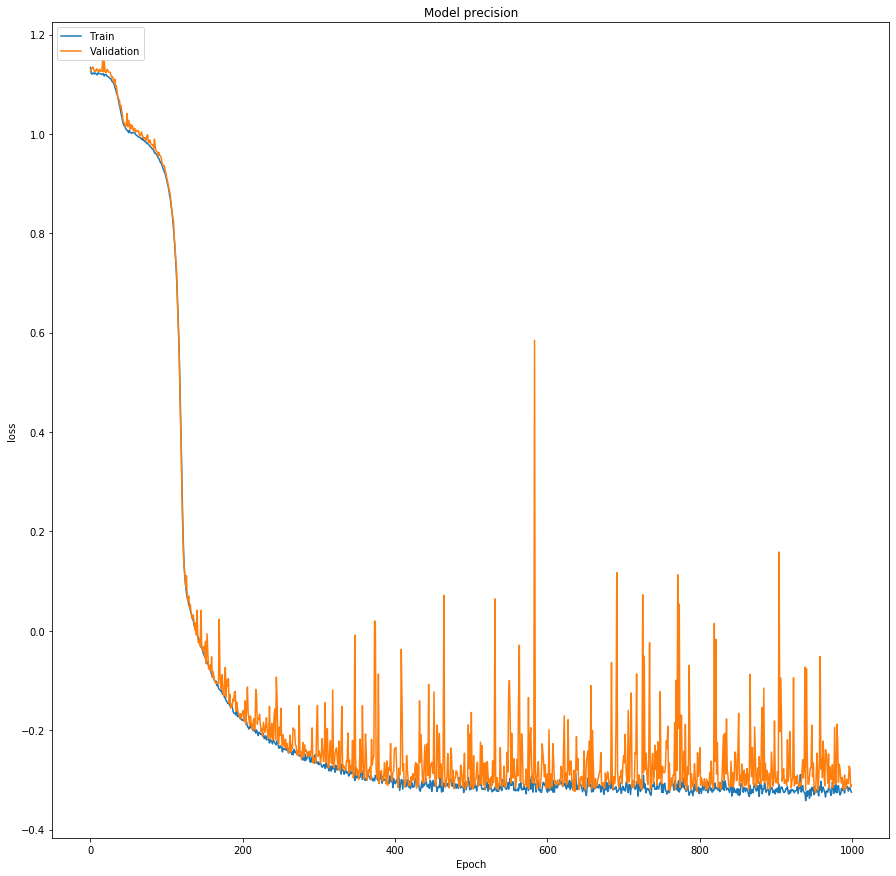

In [13]:
plt.figure(figsize=(15,15))
plt.plot(history_cache.history['loss'])
plt.plot(history_cache.history['val_loss'])
plt.title('Model precision')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper left')

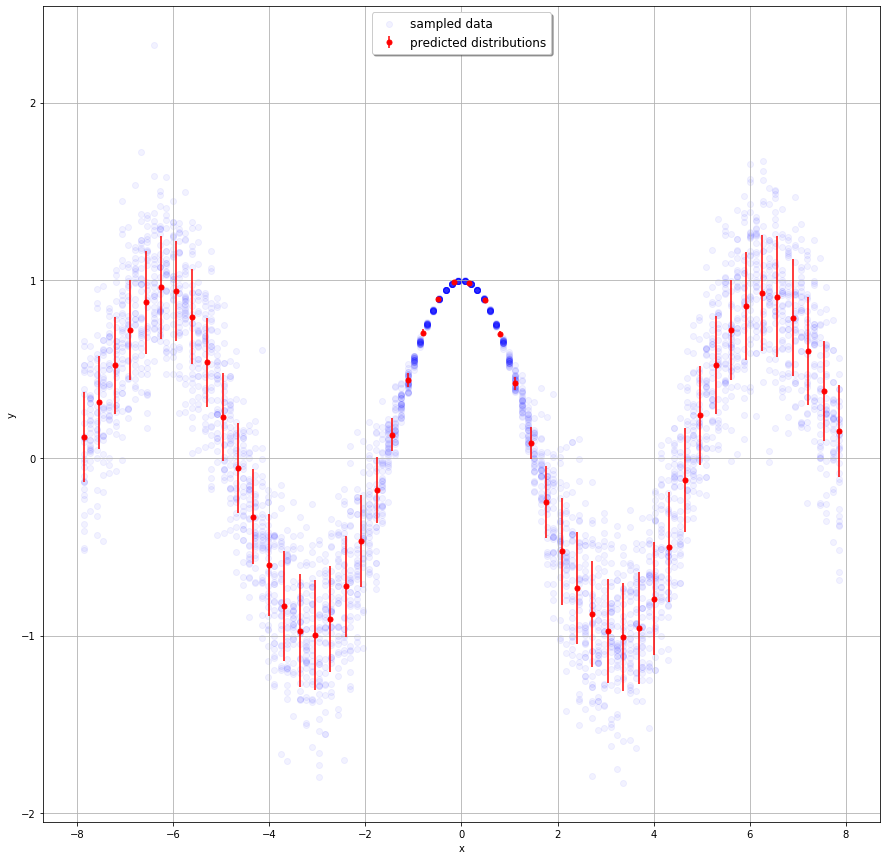

In [18]:
xtest = np.linspace(-np.pi*5/2,np.pi*5/2,50)
mu_pred, sigma_pred = model.predict(list((xtest,xtest))) # the model expects a list of arrays as it has 2 inputs
fig, ax = plt.subplots(figsize=(15,15))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.errorbar(xtest,mu_pred,yerr=np.absolute(sigma_pred),c='r',ls='None',marker='.',ms=10,label='predicted distributions')
ax.scatter(xtrain,ytrain,c='b',alpha=0.05,label='sampled data')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

## This graph bellow is showing the actual learned function with the blue line, the blue dots are the training points we used and the yellow are the test points

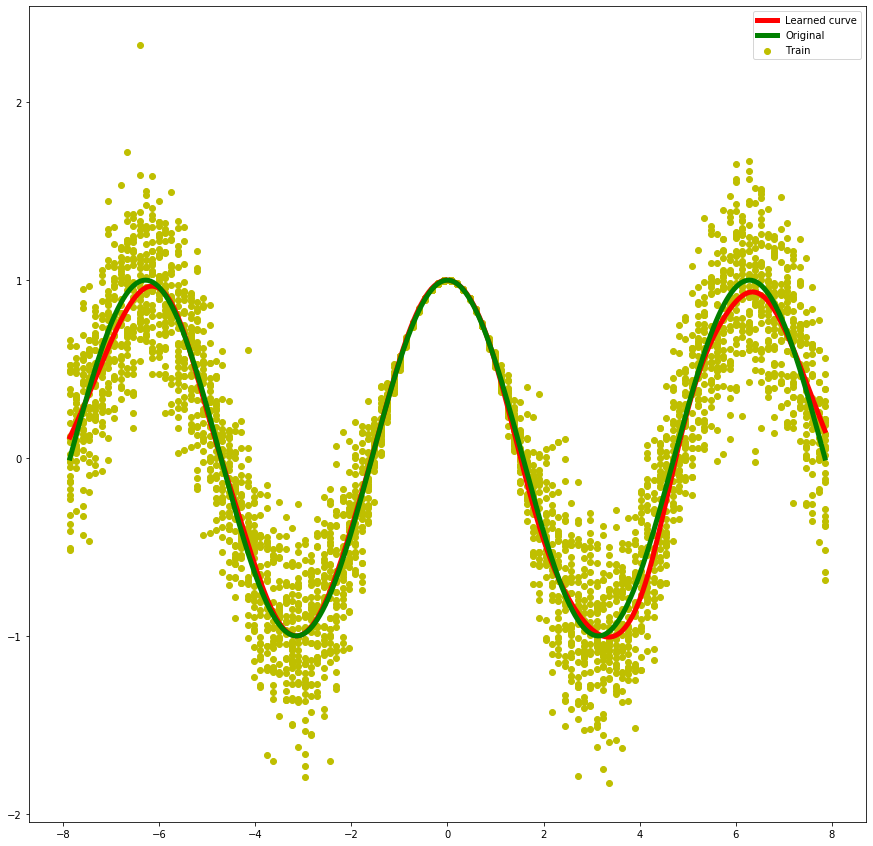

In [19]:
xpredict = np.linspace(-np.pi*5/2,np.pi*5/2,300)
ypredict = model.predict(list((xpredict,xpredict)))
plt.figure(figsize=(15,15))
plt.plot(xpredict,ypredict[0], color='r',lw=5)
plt.plot(xpredict,np.cos(xpredict),color='g',lw=5)
plt.scatter(xtrain,ytrain, color='y')
#plt.scatter(xtest,ytest)
plt.legend(['Learned curve','Original','Train','Test'])

## Now we can calculate the RÂ² value for this regressor to assess the performance of the network

In [20]:
originalFunction = np.cos(xpredict)
r2_score(ypredict[0],originalFunction)

0.994421381604469

## Now to make a servable model with the weights learned by the network, we need to eliminate the input layers and loss function

In [21]:
servable_model = Model(inputs=xInputLayer, outputs=[mu,sigma])
ypredict = servable_model.predict(xpredict)